In [ ]:
pip install gym==0.7.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152 kB 10.7 MB/s 
     |████████████████████████████████| 964 kB 25.8 MB/s 
  Created wheel for gym: filename=gym-0.7.4-py3-none-any.whl size=204692 sha256=e18cae76ebbf63329ce7305ce83734065e059f262f064b08534e537ebfffbd26
  Stored in directory: /root/.cache/pip/wheels/74/77/ca/6dd62f11b2a5de609d53566cb26a4c3c0c914a3e5f21199a2f
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 1.0.5 requires gym>=0.10.5, but you have gym 0.7.4 which is incompatible.


In [ ]:
import gym
import numpy as np
import random
from gym import Env
from gym.spaces import Box
from gym.error import DependencyNotInstalled
import torch
from torch import nn #needed for building neural networks
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
from tqdm import tqdm_notebook as tqdm
from copy import copy, deepcopy
from collections import deque
print("Using torch version: {}".format(torch.__version__))
print("Using gym version: {}".format(gym.__version__))

Using torch version: 1.13.0+cu116
Using gym version: 0.7.4


In [ ]:
class ShowerEnv(Env):
    def __init__(self):
        # Actions we can take
        self.max_knob = np.pi
        # temperatures of the shower
        self.max_temperature = 100
        # action space
        self.action_space = Box(low=-self.max_knob, high=self.max_knob, shape=(1,))
        # observation_space
        self.observation_space = Box(low=np.array([0]), high=np.array([self.max_temperature]))
        # initial state
        self.state = 38 + np.random.randint(-3, 3)
        # episode length
        self.shower_length = 60
        self.ratio = 0.25
        # self.max_reward = 10

        self.a = -1
        self.b = -1

    def step(self, action):
        if action < 0 and action >= -self.max_knob:
            self.state[0] -= 1
        if action > 0 and action <= self.max_knob:
            self.state[0] += 1
        self.shower_length -= 1

        # calculate reward
        # if self.state[0] == 38:
        #     reward = 10
        # else:
        #     reward = self.a*(self.state[0]**2) + self.b*(self.state[0]) + 10
        # if self.state[0] >= 37 and self.state[0] <= 39:
        #     reward = 10
        # else:
        #     i = self.state[0] - 38
        #     # print(i)
        #     reward = -i[0]**2 + 10

        if self.state[0] >= 37 and self.state[0] <= 39:
            reward = 10
        elif self.state[0] > 39:
            i = self.state[0] - 38
            reward = 10 - 2*i[0]
        else:
            i = self.state[0] - 38
            reward = 10 + 2*i[0]

        # check if shower is done
        if self.shower_length <= 0:
            done = True
        else:
            done = False

        # Apply temperature noise
        self.state[0] += np.random.randint(-1, 1)

        # state placeholder for info
        info = {}

        # return step information
        return self.state, reward, done, info

    # def step(self, action):
    #     if action < 0 and action >= -self.max_knob:
    #         self.state[0] = self.state[0] - 0.25
    #     if action > 0 and action <= self.max_knob:
    #         self.state[0] = self.state[0] + 0.25
    #     self.shower_length -= 1

    #     # calculate reward
    #     if self.state[0] >= 37 and self.state[0] <= 39:
    #         reward = 10
    #     else:
    #         reward = self.a*(self.state[0]**2) + self.b*(self.state[0]) + 10
        

    #     # check if shower is done
    #     if self.shower_length <= 0:
    #         done = True
    #     else:
    #         done = False

    #     # Apply temperature noise
    #     self.state[0] += np.random.randint(-1, 1)

    #     # state placeholder for info
    #     info = {}

    #     # return step information
    #     return self.state, reward, done, info

    def render(self):
        # visulization Implementation
        pass
    def reset(self):
        self.state = np.array([38 + np.random.randint(-3, 3)]).reshape((1,1))
        self.shower_length = 60
        return self.state

In [ ]:
env = ShowerEnv()

Exception ignored in: <function Env.__del__ at 0x7f4fa68a3820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/gym/core.py", line 252, in __del__
  File "/usr/local/lib/python3.8/dist-packages/gym/core.py", line 188, in close
TypeError: render() got an unexpected keyword argument 'close'


In [ ]:
a = env.observation_space.sample()[0]
a

55.59850547971865

In [ ]:
BUFFER_SIZE=1000000
BATCH_SIZE=64
GAMMA=0.99
TAU=0.001       #Target Network HyperParameters Update rate
LRA=0.0001      #LEARNING RATE ACTOR
LRC=0.001       #LEARNING RATE CRITIC
H1=400   #neurons of 1st layers
H2=300   #neurons of 2nd layers

MAX_EPISODES=2000 #number of episodes of the training
MAX_STEPS=200    #max steps to finish an episode. An episode breaks early if some break conditions are met (like too much
                  #amplitude of the joints angles or if a failure occurs). In the case of pendulum there is no break 
                #condition, hence no environment reset,  so we just put 1 step per episode. 
buffer_start = 100 #initial warmup without training
epsilon = 1
epsilon_decay = 1./100000 #this is ok for a simple task like inverted pendulum, but maybe this would be set to zero for more
                     #complex tasks like Hopper; epsilon is a decay for the exploration and noise applied to the action is 
                     #weighted by this decay. In more complex tasks we need the exploration to not vanish so we set the decay
                     #to zero.
PRINT_EVERY = 10 #Print info about average reward every PRINT_EVERY

ENV_NAME = 'HalfCheetah-v1' # Put here the gym env name you want to play with
#check other environments to play with at https://gym.openai.com/envs/#mujoco

In [ ]:
class replayBuffer(object):
    def __init__(self, buffer_size, name_buffer=''):
        self.buffer_size=buffer_size  #choose buffer size
        self.num_exp=0
        self.buffer=deque()

    def add(self, s, a, r, t, s2):
        experience=(s, a, r, t, s2)
        if self.num_exp < self.buffer_size:
            self.buffer.append(experience)
            self.num_exp +=1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.buffer_size

    def count(self):
        return self.num_exp

    def sample(self, batch_size):
        if self.num_exp < batch_size:
            batch=random.sample(self.buffer, self.num_exp)
        else:
            batch=random.sample(self.buffer, batch_size)

        s, a, r, t, s2 = map(np.stack, zip(*batch))

        return s, a, r, t, s2

    def clear(self):
        self.buffer = deque()
        self.num_exp=0

In [ ]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cuda


In [ ]:
def fanin_(size):
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return torch.Tensor(size).uniform_(-weight, weight)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=3e-3):
        super(Critic, self).__init__()
                
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        #self.bn1 = nn.BatchNorm1d(h1)
        
        self.linear2 = nn.Linear(h1+action_dim, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
                
        self.linear3 = nn.Linear(h2, 1)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        
    def forward(self, state, action):
        x = self.linear1(state)
        x = self.relu(x)
        # print(f'state_size: {x.shape}')
        # print(f'action_size: {action.shape}')
        # print(f'concat_size: {torch.cat([x, action], 2).shape}')
        # x = self.linear2(torch.cat([x,action],1))
        x = self.linear2(torch.cat([x,action],2))
        x = self.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
class Actor(nn.Module): 
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=0.003):
        super(Actor, self).__init__()
        
        #self.bn0 = nn.BatchNorm1d(state_dim)
        
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        
        #self.bn1 = nn.BatchNorm1d(h1)
        
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
        
        #self.bn2 = nn.BatchNorm1d(h2)
        
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, state):
        #state = self.bn0(state)
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

In [ ]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu=0, sigma=0.2, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [ ]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [ ]:
# env = NormalizedEnv(gym.make(ENV_NAME))

env.reset()
# env.render()

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

critic  = Critic(state_dim, action_dim).to(device)
actor = Actor(state_dim, action_dim).to(device)

target_critic  = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)

for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
    
q_optimizer  = opt.Adam(critic.parameters(),  lr=LRC) #, weight_decay=0.01)
policy_optimizer = opt.Adam(actor.parameters(), lr=LRA)

MSE = nn.MSELoss()

memory = replayBuffer(BUFFER_SIZE)

State dim: 1, Action dim: 1


In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

In [ ]:
episodes = 10
for episode in range(0, episodes):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print(f'episode: {episode}, score: {score}')

episode: 0, score: -1534
episode: 1, score: -1624
episode: 2, score: -1622
episode: 3, score: -350
episode: 4, score: -1500
episode: 5, score: -1398
episode: 6, score: -1750
episode: 7, score: -348
episode: 8, score: -1292
episode: 9, score: -468


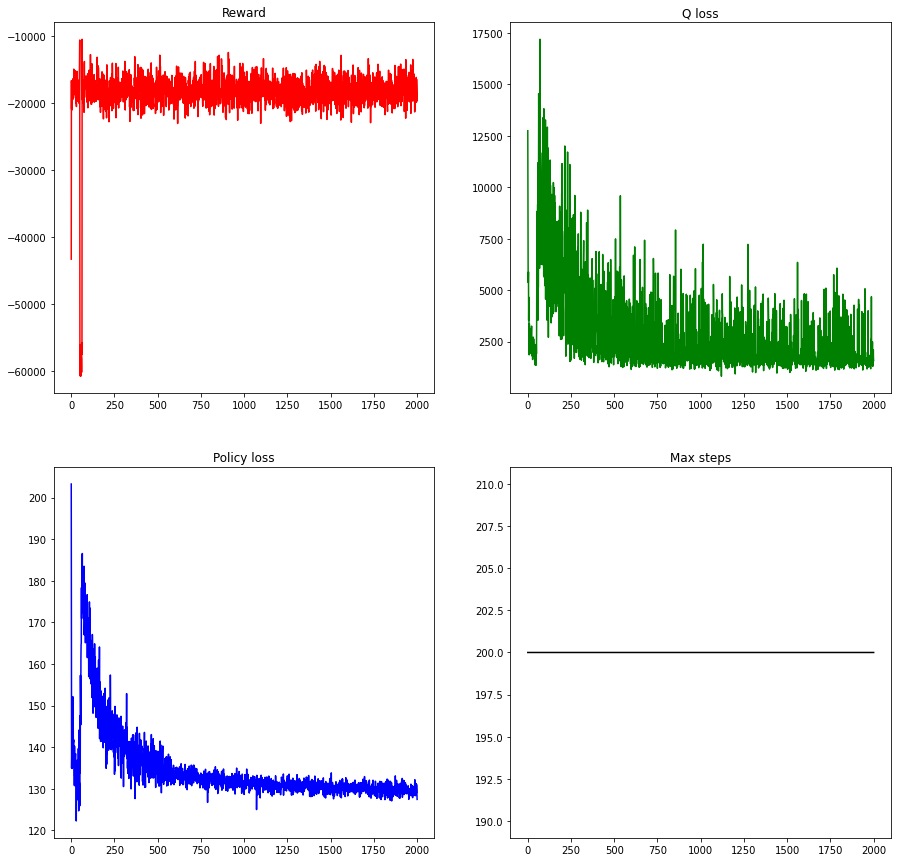

[  2000 episode,   400000 total steps] average reward for past 10 iterations: -17901.000
Last model saved with reward: -10510.00, at episode 64.


In [ ]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
#s = deepcopy(env.reset())

for episode in range(MAX_EPISODES):
    #print(episode)
    # s = deepcopy(env.reset())
    s = env.reset()
    #noise.reset()
    done = False
    ep_reward = 0.
    ep_q_value = 0.
    step=0

    for step in range(MAX_STEPS):
        #loss=0
        global_step +=1
        epsilon -= epsilon_decay
        #actor.eval()
        a = actor.get_action(s)
        #actor.train()

        a += noise()*max(0, epsilon)
        a = np.clip(a, -1., 1.)
        # env.render()
        s2, reward, terminal, info = env.step(a)

        memory.add(s, a, reward, terminal,s2)

        #keep adding experiences to the memory until there are at least minibatch size samples

        if memory.count() > buffer_start:
            s_batch, a_batch, r_batch, t_batch, s2_batch = memory.sample(BATCH_SIZE)

            s_batch = torch.FloatTensor(s_batch).to(device)
            a_batch = torch.FloatTensor(a_batch).to(device)
            r_batch = torch.FloatTensor(r_batch).unsqueeze(1).to(device)
            t_batch = torch.FloatTensor(np.float32(t_batch)).unsqueeze(1).to(device)
            s2_batch = torch.FloatTensor(s2_batch).to(device)
            
            
            #compute loss for critic
            a2_batch = target_actor(s2_batch)
            # print(f'action_size:{a2_batch.shape}')
            # print(f'state_size:{s2_batch.shape}')
            a = torch.cat([s2_batch, a2_batch])
            # print(f'concat_size: {a.shape}')
            target_q = target_critic(s2_batch, a2_batch) #detach to avoid updating target
            y = r_batch + (1.0 - t_batch) * GAMMA * target_q.detach()
            q = critic(s_batch, a_batch)
            
            q_optimizer.zero_grad()
            q_loss = MSE(q, y) #detach to avoid updating target
            q_loss.backward()
            q_optimizer.step()
            
            #compute loss for actor
            policy_optimizer.zero_grad()
            policy_loss = -critic(s_batch, actor(s_batch))
            policy_loss = policy_loss.mean()
            policy_loss.backward()
            policy_optimizer.step()

            #soft update of the frozen target networks
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

            for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

        s = deepcopy(s2)
        ep_reward += reward

    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.cpu().data, episode+1])
        plot_q.append([q_loss.cpu().data, episode+1])
        plot_steps.append([step+1, episode+1])
    except:
        continue
    average_reward += ep_reward
    
    if ep_reward > best_reward:
        torch.save(actor.state_dict(), 'best_model_pendulum.pkl') #Save the actor model for future testing
        best_reward = ep_reward
        saved_reward = ep_reward
        saved_ep = episode+1

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q, plot_steps)
        print('[%6d episode, %8d total steps] average reward for past {} iterations: %.3f'.format(PRINT_EVERY) %
            (episode + 1, global_step, average_reward / PRINT_EVERY))
        print("Last model saved with reward: {:.2f}, at episode {}.".format(saved_reward, saved_ep))
        average_reward = 0 #reset average reward